In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=11264)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the required data

In [3]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [5]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Prepare the data

In [44]:
# Image dimensions
img_height, img_width = 512, 512
crop_size = 224

# Batch size
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define number of classes
num_classes = train_generator.num_classes

Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Build model 1

In [31]:
from tensorflow.keras.applications import MobileNetV2


crop_size = 224  # Image crop size

# Define a class for a unique MobileNetV2 branch
class UniqueMobileNetV2(tf.keras.Model):
    def __init__(self, branch_name, **kwargs):
        super(UniqueMobileNetV2, self).__init__(**kwargs)
        self.branch_name = branch_name
        self.base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(crop_size, crop_size, 3), alpha=0.5)  # Use alpha to reduce complexity
        self.global_pool = GlobalAveragePooling2D()
        
    def call(self, inputs):
        x = self.base_model(inputs)
        return self.global_pool(x)
    
    def build(self, input_shape):
        super(UniqueMobileNetV2, self).build(input_shape)
        for layer in self.base_model.layers:
            layer._name = f'{self.branch_name}_{layer.name}'

def create_mobilenet_branch(input_tensor, branch_name):
    mobilenet_model = UniqueMobileNetV2(branch_name)
    return mobilenet_model(input_tensor)

def build_multibranch_network(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input')
    # Branch 1: Random crop and MobileNetV2
    x1 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch1')(inputs)
    x1 = create_mobilenet_branch(x1, 'branch1')
    # Branch 2: Random crop and MobileNetV2
    x2 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch2')(inputs)
    x2 = create_mobilenet_branch(x2, 'branch2')
    # Branch 3: Resize, crop, and MobileNetV2
    x3 = Lambda(lambda img: tf.image.resize(img, [256, 256]), name='resize_branch3')(inputs)
    x3 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch3')(x3)
    x3 = create_mobilenet_branch(x3, 'branch3')
    
    # Concatenate branches
    concatenated = tf.keras.layers.concatenate([x1, x2, x3], name='concat_branches')
    # Fully connected layer
    x = Dense(128, activation='relu', name='dense_layer')(concatenated)  # Reduced size
    x = Dense(num_classes, activation='softmax', name='output_layer')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=x, name='multibranch_model')
    return model

# Define image dimensions and number of classes
img_height, img_width = 512, 512

# Build the model
model = build_multibranch_network((img_height, img_width, 3), num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "multibranch_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resize_branch3 (Lambda)        (None, 256, 256, 3)  0           ['input[0][0]']                  
                                                                                                  
 crop_branch1 (Lambda)          (None, 224, 224, 3)  0           ['input[0][0]']                  
                                                                                                  
 crop_branch2 (Lambda)          (None, 224, 224, 3)  0           ['input[0][0]']  

# Model training

In [34]:
# Ensure the checkpoint filename is unique
checkpoint_file = f'model6b_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
# Define callbacks with the unique checkpoint file name
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Calculate steps per epoch
train_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
val_steps_per_epoch = np.ceil(val_generator.samples / batch_size)

# Train the model and capture the history
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.5873
Epoch 1: val_accuracy improved from -inf to 0.55793, saving model to model6b_20240803-084921.h5
1899/1899 [==============================] - 2801s 1s/step - loss: 1.1954 - accuracy: 0.5873 - val_loss: 1.3254 - val_accuracy: 0.5579
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 1.1527 - accuracy: 0.6000
Epoch 2: val_accuracy improved from 0.55793 to 0.57820, saving model to model6b_20240803-084921.h5
1899/1899 [==============================] - 2776s 1s/step - loss: 1.1527 - accuracy: 0.6000 - val_loss: 1.2461 - val_accuracy: 0.5782
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 1.0846 - accuracy: 0.6229
Epoch 3: val_accuracy did not improve from 0.57820
1899/1899 [==============================] - 2837s 1s/step - loss: 1.0846 - accuracy: 0.6229 - val_loss: 1.3968 - val_accuracy: 0.5442
Epoch 4/10
1899/1899 [==============================] -

# Evaluate the model

In [35]:
model.load_weights('model6b_20240803-084921.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 93s 390ms/step - loss: 1.2092 - accuracy: 0.6022
Test accuracy: 0.6021888256072998


# Plot Accuracy and loss graphs

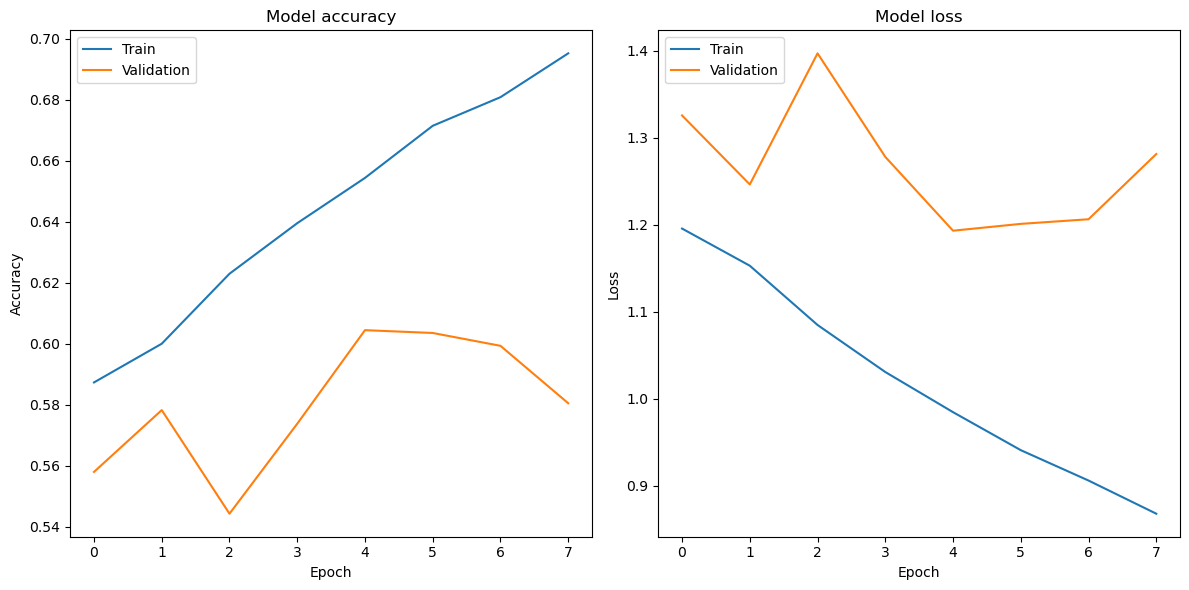

In [37]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Plot confusion matrix and classification metrics

238/238 [==============================] - 91s 383ms/step


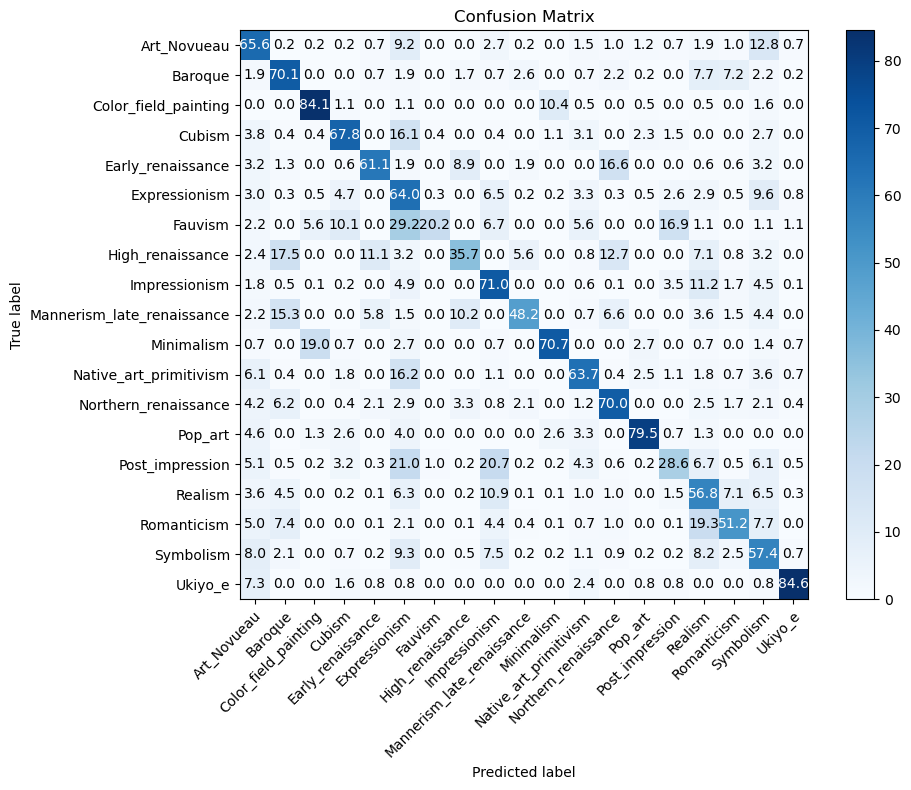

                            precision    recall  f1-score   support

               Art_Novueau       0.51      0.66      0.57       413
                   Baroque       0.61      0.70      0.65       418
      Color_field_painting       0.78      0.84      0.81       182
                    Cubism       0.68      0.68      0.68       261
         Early_renaissance       0.71      0.61      0.66       157
             Expressionism       0.45      0.64      0.53       659
                   Fauvism       0.67      0.20      0.31        89
          High_renaissance       0.48      0.36      0.41       126
             Impressionism       0.71      0.71      0.71      1314
Mannerism_late_renaissance       0.66      0.48      0.56       137
                Minimalism       0.77      0.71      0.74       147
    Native_art_primitivism       0.61      0.64      0.62       278
      Northern_renaissance       0.64      0.70      0.67       240
                   Pop_art       0.80      0.79

In [39]:
class_names = list(train_generator.class_indices.keys())

# Reset the test generator and make predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f'  # Format as percentage with one decimal place
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(cm_percentage, class_names)
plt.show()

# Print classification report for further evaluation
print(classification_report(y_true, y_pred, target_names=class_names))


# Build Model 2

In [47]:
# Enable mixed precision for faster computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Parameters
crop_size = 224  # Image crop size
img_height, img_width = 256, 256  # Reduced input dimensions
batch_size = 32  # Increased batch size for faster training

# Define a class for a custom denser Xception branch
class DenserXception(tf.keras.Model):
    def __init__(self, branch_name, **kwargs):
        super(DenserXception, self).__init__(**kwargs)
        self.branch_name = branch_name
        
        # Define a denser version of Xception
        self.conv1 = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')

        self.sep_conv1 = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.sep_conv2 = SeparableConv2D(64, (3, 3), padding='same', use_bias=False)
        self.bn3 = BatchNormalization()
        self.act3 = Activation('relu')
        self.pool1 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        self.sep_conv3 = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)
        self.bn4 = BatchNormalization()
        self.act4 = Activation('relu')
        self.sep_conv4 = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)
        self.bn5 = BatchNormalization()
        self.act5 = Activation('relu')
        self.pool2 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        self.sep_conv5 = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)
        self.bn6 = BatchNormalization()
        self.act6 = Activation('relu')
        self.sep_conv6 = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)
        self.bn7 = BatchNormalization()
        self.act7 = Activation('relu')
        self.pool3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')

        self.global_pool = GlobalAveragePooling2D()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.sep_conv1(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.sep_conv2(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool1(x)

        x = self.sep_conv3(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.sep_conv4(x)
        x = self.bn5(x)
        x = self.act5(x)
        x = self.pool2(x)

        x = self.sep_conv5(x)
        x = self.bn6(x)
        x = self.act6(x)
        x = self.sep_conv6(x)
        x = self.bn7(x)
        x = self.act7(x)
        x = self.pool3(x)

        return self.global_pool(x)
    
    def build(self, input_shape):
        super(DenserXception, self).build(input_shape)
        for layer in self.layers:
            layer._name = f'{self.branch_name}_{layer.name}'

def create_xception_branch(input_tensor, branch_name):
    xception_model = DenserXception(branch_name)
    return xception_model(input_tensor)

def build_multibranch_network(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input')
    
    # Branch 1: Random crop and Denser Xception
    x1 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch1')(inputs)
    x1 = create_xception_branch(x1, 'branch1')
    
    # Branch 2: Random crop and Denser Xception
    x2 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch2')(inputs)
    x2 = create_xception_branch(x2, 'branch2')
    
    # Branch 3: Resize, crop, and Denser Xception
    x3 = Lambda(lambda img: tf.image.resize(img, [crop_size + 32, crop_size + 32]), name='resize_branch3')(inputs)
    x3 = Lambda(lambda img: tf.image.random_crop(img, size=[tf.shape(img)[0], crop_size, crop_size, 3]), name='crop_branch3')(x3)
    x3 = create_xception_branch(x3, 'branch3')
    
    # Concatenate branches
    concatenated = concatenate([x1, x2, x3], name='concat_branches')
    
    # Fully connected layer
    x = Dense(512, activation='relu', name='dense_layer1')(concatenated)  # Increased size
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', name='dense_layer2')(x)  # Additional dense layer
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='output_layer')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=x, name='multibranch_model')
    return model

# Build the model
model = build_multibranch_network((img_height, img_width, 3), num_classes)

# Compile the model with mixed precision
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
Model: "multibranch_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resize_branch3 (Lambda)        (None, 256, 256, 3)  0           ['input[0][0]']                  
                                                                                                  
 crop_branch1 (Lambda)      

# Model 2 training 

In [49]:
# Ensure the checkpoint filename is unique
checkpoint_file = f'model62_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'

# Define callbacks with the unique checkpoint file name
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Calculate steps per epoch
train_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
val_steps_per_epoch = np.ceil(val_generator.samples / batch_size)

# Train the model and capture the history
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.4753 - accuracy: 0.2187
Epoch 1: val_accuracy improved from -inf to 0.29239, saving model to model62_20240803-162911.h5
1899/1899 [==============================] - 2683s 1s/step - loss: 2.4753 - accuracy: 0.2187 - val_loss: 2.1762 - val_accuracy: 0.2924
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.2655 - accuracy: 0.2692
Epoch 2: val_accuracy improved from 0.29239 to 0.31003, saving model to model62_20240803-162911.h5
1899/1899 [==============================] - 2719s 1s/step - loss: 2.2655 - accuracy: 0.2692 - val_loss: 2.1520 - val_accuracy: 0.3100
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.1802 - accuracy: 0.2903
Epoch 3: val_accuracy improved from 0.31003 to 0.32478, saving model to model62_20240803-162911.h5
1899/1899 [==============================] - 2688s 1s/step - loss: 2.1802 - accuracy: 0.2903 - val_loss: 2.0777 - val_accuracy: 0.3248
Epoch 4

# Plot accuracy and loss graphs and confusion matrix and classification metrics

238/238 [==============================] - 95s 395ms/step - loss: 1.8464 - accuracy: 0.3869
Test accuracy: 0.3869141638278961
238/238 [==============================] - 90s 374ms/step
Classification Report
                            precision    recall  f1-score   support

               Art_Novueau       0.29      0.23      0.26       413
                   Baroque       0.30      0.52      0.38       418
      Color_field_painting       0.58      0.73      0.65       182
                    Cubism       0.36      0.43      0.39       261
         Early_renaissance       0.34      0.31      0.32       157
             Expressionism       0.28      0.33      0.30       659
                   Fauvism       0.29      0.15      0.19        89
          High_renaissance       0.50      0.01      0.02       126
             Impressionism       0.55      0.62      0.58      1314
Mannerism_late_renaissance       0.24      0.06      0.09       137
                Minimalism       0.63      0.

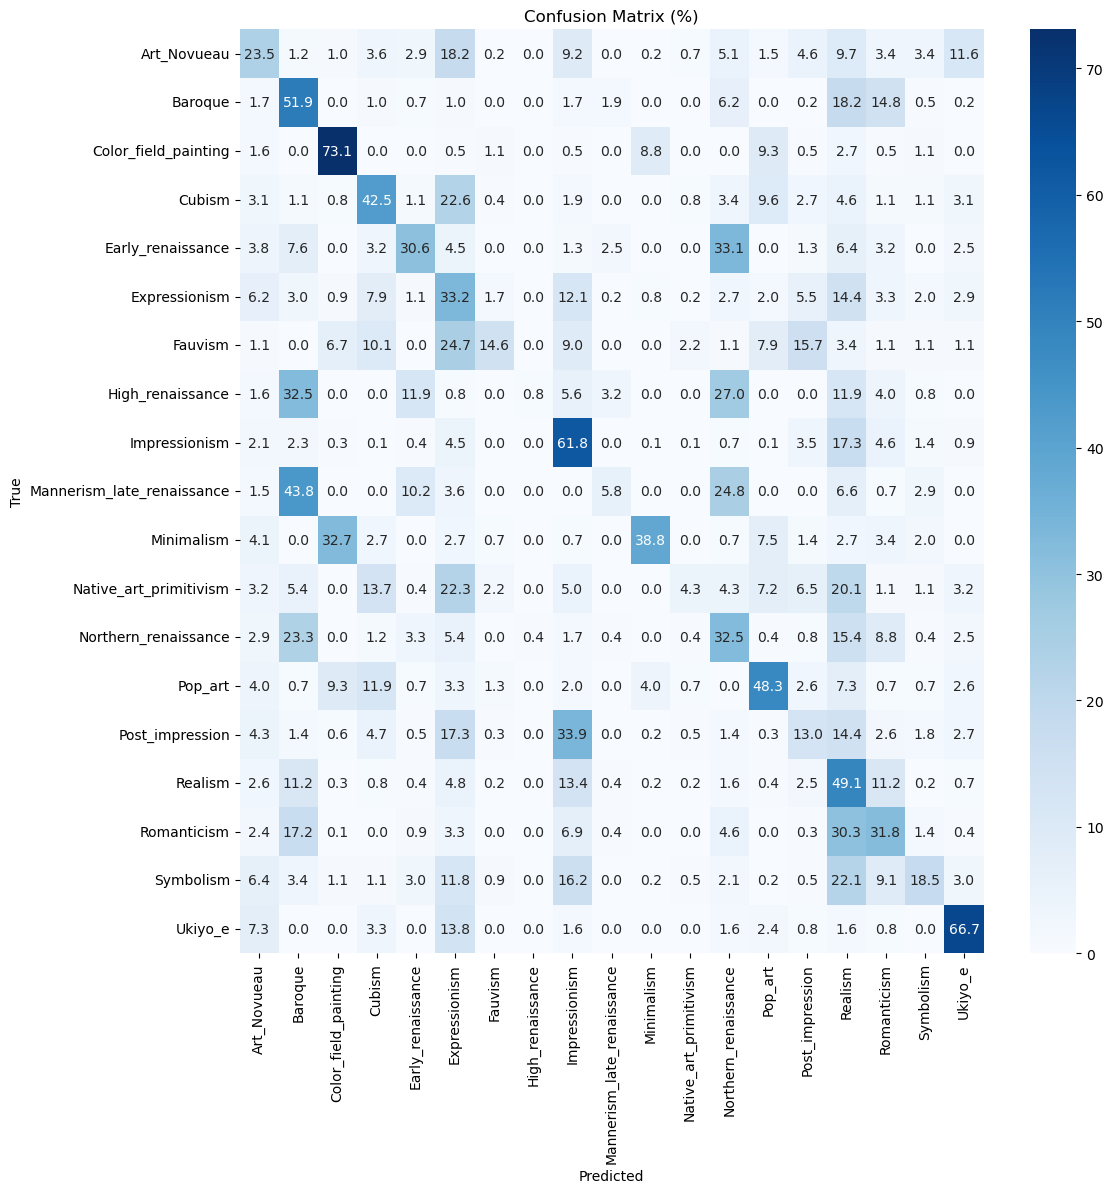

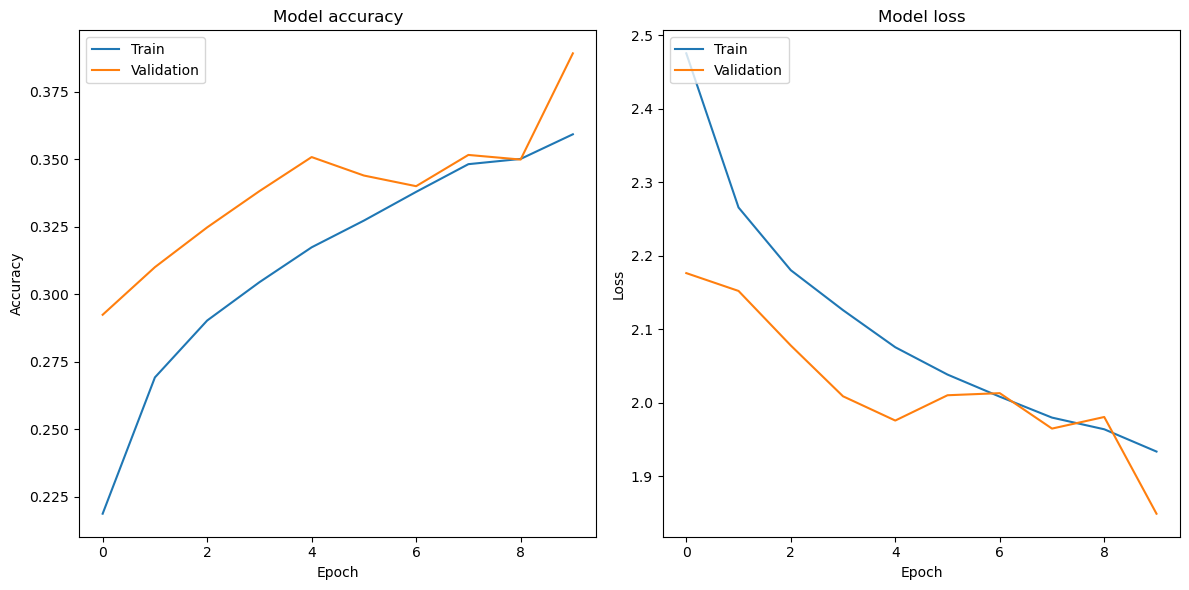

In [50]:
# Load the best model weights
model.load_weights(checkpoint_file)

# Evaluate the model on the test set
test_steps_per_epoch = np.ceil(test_generator.samples / batch_size)
loss, accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print(f'Test accuracy: {accuracy}')

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Print classification report
class_names = list(test_generator.class_indices.keys())
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(12, 12))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (%)')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()